In [60]:
import dwave
import dimod
import neal
import os
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary
from neal import SimulatedAnnealingSampler
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np


from utils.utils import get_index, get_generator_and_day
from utils.plots import plot_schedule

ModuleNotFoundError: No module named 'utils.utils'; 'utils' is not a package

# Problem definition

**Variables**
- N: number of power plants (n = 1, ..., N)
- T: time periods (t = 1, ..., T)
- i(n,t): composite index of size NT
- x_i: binary vector of size NT indicating the state of power plant (x_00 = 0 -> off, x_00 = 1 -> on)
- Q_(i, i): qubo matrix
- C_i: vector representing the cost of operating each power plant n at time t
- D(t): demand for a time period
- E_i: vector representing the efficiency of each power plant n at time t

In [11]:
n_generators = 5
n_hours = 12
size = n_hours * n_generators

C = np.random.randint(1, 11, size= size)     # cost of power plants at different hours
E = np.random.randint(1, 11, size=size)     # efficiency of power plants at different times
D = 100     # demand for a specific time period

In [12]:
# Find composite index into 1D list for (generator, hour)
def get_index(generator_index, hour_index, n_hours):
    return generator_index * n_hours + hour_index

# Inverse of get_index - given a composite index in a 1D list, return the
# generator and hour
def get_generator_and_day(index, hours):
    generator_index, hour_index = divmod(index, hours)
    return generator_index, hour_index

def create_matrix(diagonal_vector):
    n = len(diagonal_vector)
    matrix = np.zeros((n, n))
    np.fill_diagonal(matrix, diagonal_vector)
    return matrix

In [13]:
#QUBO matrix definition
qubo_matrix = create_matrix(C)

# Quadratic Unconstrained Model

In [40]:
bqm = BinaryQuadraticModel.from_qubo(qubo_matrix)
cqm = ConstrainedQuadraticModel.from_bqm(bqm)

In [41]:
#define the variables
x = {(n, t): Binary('x{}_{}'.format(n, t)) for n in range(n_generators) for t in range(n_hours)}

In [43]:
x[0,0]

BinaryQuadraticModel({'x0_0': 1.0}, {}, 0.0, 'BINARY')

In [44]:
#define the contraints
sum = 0
for hour in range(n_hours):
    for generator in range(n_generators):
        index = get_index(generator, hour, n_hours)
        sum += E[index] * x[generator, hour]
    cqm.add_constraint(sum >= D)

In [45]:
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample

 
==============================BEST SAMPLE SET==============================
    0   1   2   3   4   5   6   7   8   9  10  11 ... x4_11 energy num_oc. ...
0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   0.0    0.0       1 ...
1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   0.0    0.0       1 ...
6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   0.0    0.0       1 ...
8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...   1.0    0.0       1 ...
['INTEGER', 10 rows, 10 samples, 120 variables]


In [46]:
best_sample

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 'x0_0': 1.0,
 'x1_0': 1.0,
 'x2_0': 1.0,
 'x3_0': 1.0,
 'x4_0': 1.0,
 'x0_1': 1.0,
 'x1_1': 1.0,
 'x2_1': 1.0,
 'x3_1': 1.0,
 'x4_1': 1.0,
 'x0_2': 1.0,
 'x1_2': 1.0,
 'x2_2': 1.0,
 'x3_2': 1.0,
 'x4_2': 1.0,
 'x0_3': 1.0,
 'x1_3': 1.0,
 'x2_3': 0.0,
 'x3_3': 0.0,
 'x4_3': 0.0,
 'x0_4': 1.0,
 'x1_4': 1.0,
 'x2_4': 0.0,
 'x3_4': 1.0,
 'x4_4': 1.0,
 'x0_5': 0.0,
 'x1_5': 0.0,
 'x2_5': 1.0,
 'x3_5': 0.0,
 'x4

In [52]:
filtered_dict = {k: v for k, v in best_sample.items() if 'x' in str(k)}
filtered_keys = [key for key, value in filtered_dict.items() if value == 1]
completed_list = [item + '0' if len(item) == 2 else item for item in filtered_keys]
new_list = [(int(item.split('_')[0][1:]), int(item.split('_')[1])) for item in completed_list]

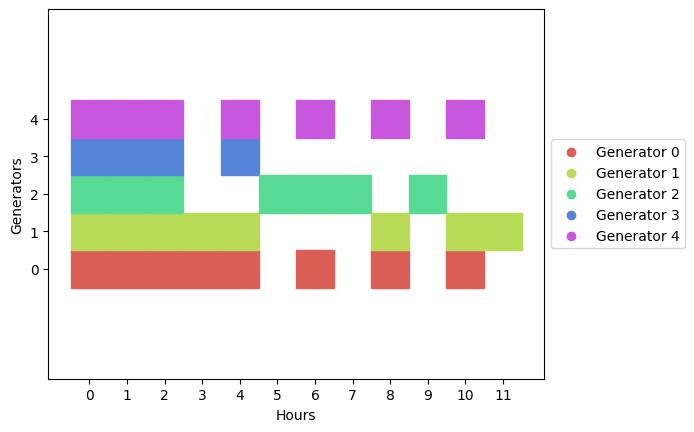

In [55]:
plot_schedule(new_list, n_hours, n_generators, save_image=False, image_path=None)

Text(0, 0.5, 'Generators')

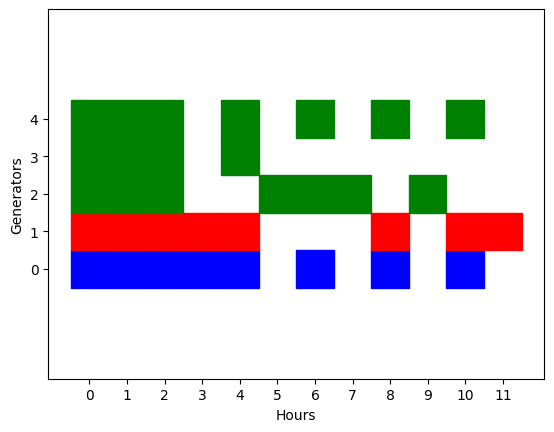

In [53]:
# Save image of schedule
x,y = zip(*new_list)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y, x)
width = 1
height = 1
for a_y, a_x in new_list:
    if a_y == 0:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='blue', fill=True))
    elif a_y == 1:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='red', fill=True))
    else:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='green', fill=True))
ax.axis('equal')
ax.set_xticks(range(n_hours))
ax.set_yticks(range(n_generators))
ax.set_xlabel("Hours")
ax.set_ylabel("Generators")